In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from os.path import join, basename

import urllib.request
import numpy as np
import cv2
import torch

In [3]:
from lib.r2d2.extract import extract_keypoints

from relfm.utils.visualize import show_single_image, show_grid_of_images, show_keypoint_matches

In [50]:
def download_file(url, path):
    """Downloads file at URL `url` to local path `path`."""
    urllib.request.urlretrieve(url, path)

In [51]:
# download model checkpoint

URL = "https://github.com/naver/r2d2/raw/master/models/r2d2_WASF_N16.pt"

model_dir = "../checkpoints/"
os.makedirs(model_dir, exist_ok=True)

path = join(model_dir, basename(URL))
download_file(URL, path)

In [52]:
# check downloaded file
# ckpt = np.load(path, allow_pickle=True)
ckpt = torch.load(path)

In [54]:
ckpt.keys()

dict_keys(['net', 'state_dict'])

In [198]:
img1_path = "../sample_images/house1.png"
img2_path = "../sample_images/house2_rotated.png"

In [199]:
args = {
    "model": path,
    "images": [img1_path, img2_path],
    "tag": "r2d2",
    "top_k": 5000,
    "scale_f": 2**0.25,
    "min_size": 256,
    "max_size": 1024,
    "min_scale": 0,
    "max_scale": 1,
    "reliability_thr": 0.7,
    "repeatability_thr": 0.7,
    "gpu": -1,
}

In [200]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [201]:
args = dotdict(args)

In [202]:
extract_keypoints(args)

Launching on CPU

>> Creating net = Quad_L2Net_ConfCFS()
 ( Model size: 486K parameters )

Extracting features for ../sample_images/house1.png
extracting at scale x1.00 =  512x480
extracting at scale x0.84 =  431x404
extracting at scale x0.71 =  362x339
extracting at scale x0.59 =  304x285
extracting at scale x0.50 =  256x240
Saving 2615 keypoints to ../sample_images/house1.png.r2d2

Extracting features for ../sample_images/house2_rotated.png
extracting at scale x1.00 =  512x480
extracting at scale x0.84 =  431x404
extracting at scale x0.71 =  362x339
extracting at scale x0.59 =  304x285
extracting at scale x0.50 =  256x240
Saving 2502 keypoints to ../sample_images/house2_rotated.png.r2d2


### Visualize matches

In [203]:
img1 = cv2.cvtColor(cv2.imread(img1_path), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread(img2_path), cv2.COLOR_BGR2RGB)

img1_outputs = np.load(img1_path + "." + args.tag)
img2_outputs = np.load(img2_path + "." + args.tag)

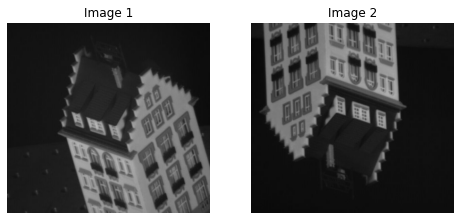

In [204]:
show_grid_of_images([img1, img2], n_cols=2, subtitles=["Image 1", "Image 2"])

In [205]:
kp1 = [cv2.KeyPoint(*coord) for coord in img1_outputs["keypoints"]]
img1_with_kps = cv2.drawKeypoints(img1, kp1, np.array([]), (255,0,0))

kp2 = [cv2.KeyPoint(*coord) for coord in img2_outputs["keypoints"]]
img2_with_kps = cv2.drawKeypoints(img2, kp2, np.array([]), (255,0,0))

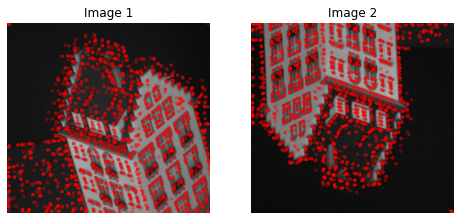

In [206]:
show_grid_of_images([img1_with_kps, img2_with_kps], n_cols=2, subtitles=["Image 1", "Image 2"])

In [207]:
def mnn_matcher(descriptors_a, descriptors_b):
    """
    Borrowed from: D2Net's HPatches benchmark notebook.
    Link: https://github.com/mihaidusmanu/d2-net/blob/master/hpatches_sequences/HPatches-Sequences-Matching-Benchmark.ipynb
    """
    device = descriptors_a.device
    sim = descriptors_a @ descriptors_b.t()
    nn12 = torch.max(sim, dim=1)[1]
    nn21 = torch.max(sim, dim=0)[1]
    ids1 = torch.arange(0, sim.shape[0], device=device)
    mask = (ids1 == nn21[nn12])
    matches = torch.stack([ids1[mask], nn12[mask]])
    dist = 1- sim[[matches[0], matches[1]]]
    return dist.data.cpu().numpy(), matches.t().data.cpu().numpy()

In [208]:
# find matches and show them

# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors.
des1 = img1_outputs["descriptors"]
des2 = img2_outputs["descriptors"]
dist, _matches = mnn_matcher(torch.from_numpy(des1), torch.from_numpy(des2))

# sort based on distances
order = np.argsort(dist)
_matches = _matches[order]
dist = dist[order]

matches = []
for (x, y), d in zip(_matches, np.round(dist, 1)):
    matches.append(cv2.DMatch(_queryIdx=x, _trainIdx=y, _distance=d))

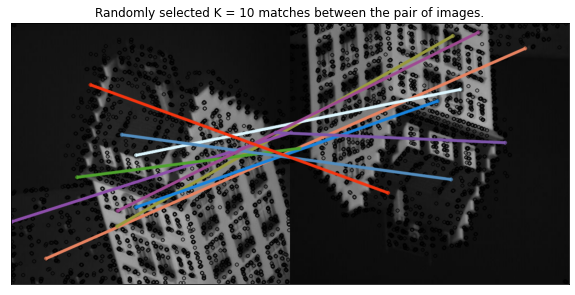

In [209]:
matches_img = show_keypoint_matches(img1, kp1, img2, kp2, matches)